# Code example
- **Generating the sequence of requests based on a list of past executions**
- **Computing the cost of a sequence for new executions**

Input data is represented by:
 * An array of past execution times

Default case (no parameters are set)
- Computes the sequence using Distribution Interpolation if the array of past executions has less than 100 entries
- Computes the sequence using discrete data otherwise
- Assumes the application cannot be checkpointed

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random

import sys
sys.path.append("..")
import iSBatch

# Read input data

Input data should be an array with each element representing one execution

In [2]:
dataset = "./logs/truncnorm.in"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 1000


# Compute the discrete CDF

Compute the discrete CDF, it's cost on the same data (optimal cost), compute the sequence and plot them

In [3]:
# Optimal CDF by using the discrete full data both for computing the data and for computing the cost
params = iSBatch.ResourceParameters()
params.resource_discretization = 1000
    
wf = iSBatch.ResourceEstimator(data, params=params)
optimal_data, optimal_cdf = wf._get_cdf()

optimal_sequence = wf.compute_request_sequence()
print("Optimal sequence", optimal_sequence)

optimal_cost = wf.compute_sequence_cost(optimal_sequence, data)
print("Optimal cost", optimal_cost)

Optimal sequence [(11.215230398339102, 0), (13.33928544239686, 0)]
Optimal cost 20.42638202879111


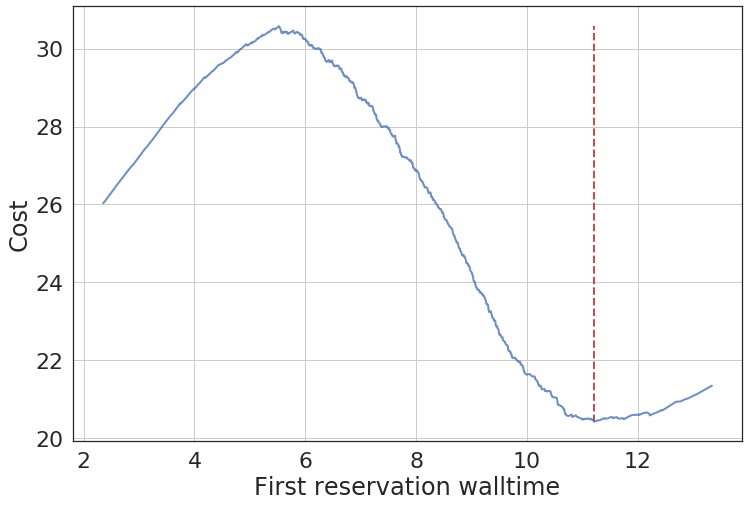

In [4]:
# Plot the cost of the first reservation using raw data from the log
# - highlight the chosen first reservation

cost = []
data.sort()
for i in data:
    cost.append(wf.compute_sequence_cost([(i, 0), (optimal_sequence[1][0], 0)],
                                         data))
sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data, cost, 'b', lw=2, alpha=0.8)
ax.vlines(optimal_sequence[0][0], min(cost), max(cost), colors='r', lw=2,
          linestyles='dashed')
plt.grid(True)
ax.set_xlabel('First reservation walltime')
ax.set_ylabel('Cost')
#plt.savefig("./%s.png" %(dataset.split(".")[1]), bbox_inches='tight')
plt.show()

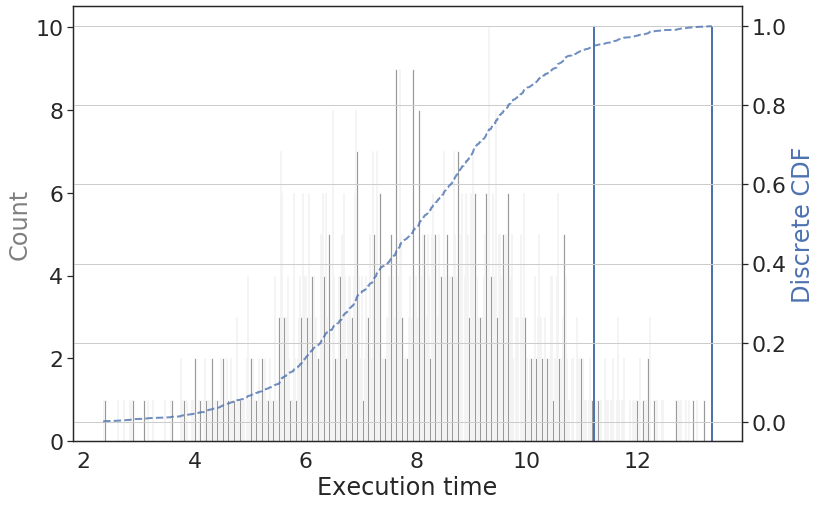

In [5]:
# plot the data and the discrete CDF (consecutive points joined by a line)

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot discrete fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8)

plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF', color="b")
ax.set_ylabel('Count', color="grey")
plt.show()

# Interpolate the CDF with a distribution fit

- Overwrite the default that uses discrete for logs bigger than 100 elements

In [6]:
# force Interpolation fit
params = iSBatch.ResourceParameters()
params.interpolation_model = iSBatch.DistInterpolation()
wf = iSBatch.ResourceEstimator(data, params=params)

In [7]:
all_data_discrete, all_data_cdf = wf._get_cdf()
best_fit = wf._get_best_fit()
distr_sequence = wf.compute_request_sequence()
print("Distribution sequence", distr_sequence)

Distribution sequence [(11.511610777571594, 0), (13.33928544239686, 0)]


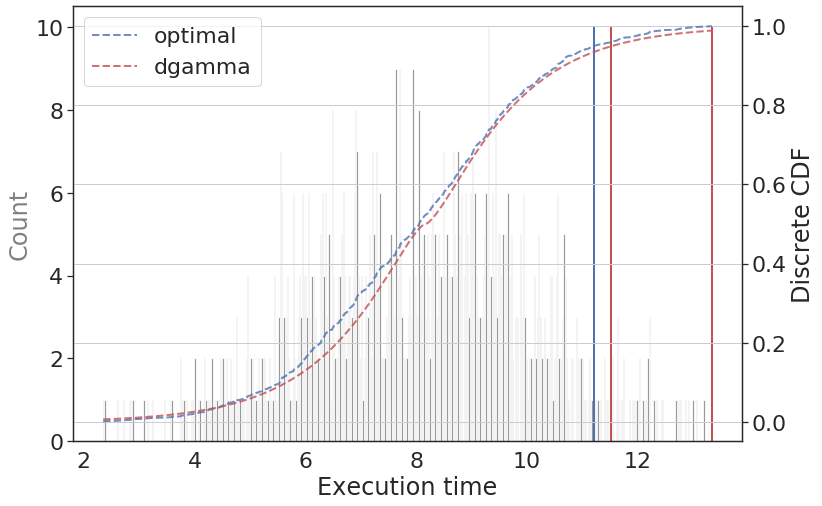

In [8]:
# plot the data and the interpolation CDF

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
#plt.savefig("docs/sequence.png")
plt.show()

# Use only the first x entries in data for interpolation

In [9]:
# define x
training_size = 10

In [10]:
# the training data must include the max expected execution time
training_data = random.sample(list(data), training_size) + [max(data)]

# force to use discrete CDF
params = iSBatch.ResourceParameters()
params.interpolation_model = []
wf = iSBatch.ResourceEstimator(training_data, params=params)
discret_data, cdf = wf._get_cdf()

discrete_sequence = wf.compute_request_sequence()
print("Discrete sequence", discrete_sequence)
print("Discrete cost", wf.compute_sequence_cost(discrete_sequence, data))

Discrete sequence [(10.597825836547681, 0), (13.33928544239686, 0)]
Discrete cost 20.831957539745485


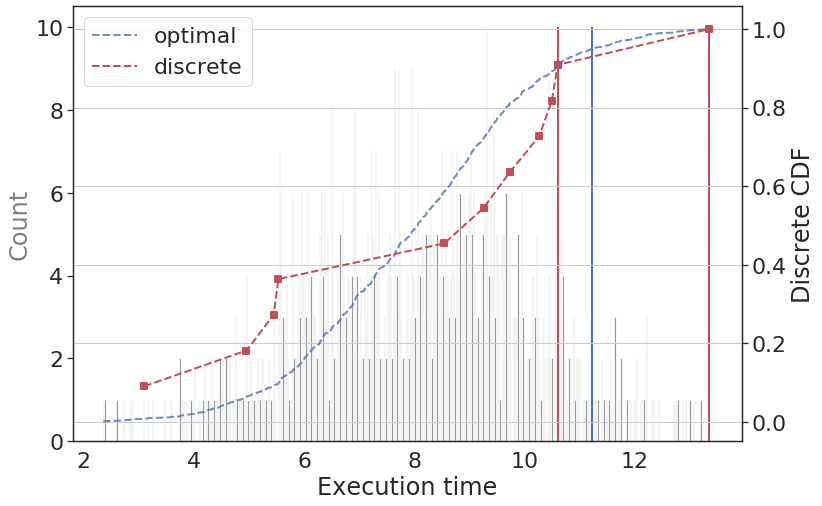

In [11]:
# plot the fit of the discrete fit (using the first x entries)

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')


# plot the discrete sequence
ax.vlines(discrete_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# plot sample data
ax2.plot(discret_data + [max(data)], cdf + [1], 'r--', lw=2, alpha=1, label="discrete")
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)

ax2.legend(shadow=True)
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()

# Distribution interpolation

In [12]:
# compute the interpolation of the CDF points
wf = iSBatch.ResourceEstimator(training_data)
distr_sequence = wf.compute_request_sequence()

best_fit = wf._get_best_fit()
print(best_fit)
all_data_discrete, all_data_cdf = wf._get_cdf()

print("Distribution sequence", distr_sequence)
print("Distribution cost", wf.compute_sequence_cost(distr_sequence, data))

(<scipy.stats._continuous_distns.dweibull_gen object at 0x7fc3a67d8690>, (2.328110190867829, 7.51354317008044, 3.154496278975266), 2.978577974300688)
Distribution sequence [(12.456799987173847, 0), (13.33928544239686, 0)]
Distribution cost 20.72274119572551


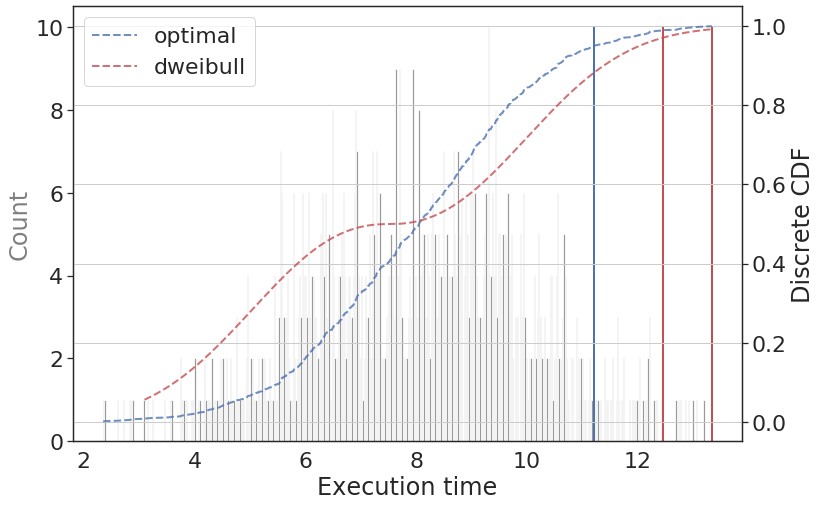

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax2 = ax.twinx()
# plot data
counts, bins = np.histogram(data, bins=500)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8, color="grey")

# plot optimal sequence
ax.vlines(optimal_sequence[0][0], min(counts), max(counts), colors='b', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(optimal_sequence)):
    ax.vlines(optimal_sequence[i][0], min(counts), max(counts), colors='b', lw=2, linestyles='solid')

# plot polynomial fit sequence
ax.vlines(distr_sequence[0][0], min(counts), max(counts), colors='r', lw=2,
          linestyles='solid', label='optimal')
for i in range(1,len(distr_sequence)):
    ax.vlines(distr_sequence[i][0], min(counts), max(counts), colors='r', lw=2, linestyles='solid')

# plot optimal fit
ax2.plot(optimal_data, optimal_cdf, 'b--', lw=2, alpha=0.8, label="optimal")

# polynomial fit
ax2.plot(all_data_discrete, all_data_cdf, 'r--', lw=2, alpha=0.8, label=best_fit[0].name)

ax2.legend(shadow=True, title="Interpolation")
plt.legend(loc='upper left')
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="grey")
plt.show()

# Dynamic checkpointing
- **Compute the sequence of requests for dynamic memory footprint**

Using the SLANT logs

Compare the sequences to using the maximum / avg footprint in a static way

In [14]:
history = np.loadtxt("./logs/SLANT_walltime.log", delimiter=' ')
memory_footprint = np.loadtxt("./logs/SLANT_memory.log", delimiter=',')

# only keep entris similar to the examples in the log folder
history = [i for i in history if i < 8500]

### Using static checkpointing
- With the checkpoint size max of the memory footprint

In [15]:
# Assume bandwidth of 20 MB/s for each core

check_model = iSBatch.StaticCheckpointMemoryModel(
        checkpoint_cost=np.max(memory_footprint)/50,
        restart_cost=np.max(memory_footprint)/50)
cl_cost = iSBatch.ClusterCosts(checkpoint_memory_model=check_model)

params = iSBatch.ResourceParameters()
params.CR_strategy = iSBatch.CRStrategy.AlwaysCheckpoint
wl = iSBatch.ResourceEstimator(history, params=params)
sequence_static = wl.compute_request_sequence(cluster_cost=cl_cost)
sequence_static

[(8443.987975951904, 1), (40.26052104208429, 1), (5.751503006011262, 0)]

### Using dynamic checkpointing

In [16]:
check_model = iSBatch.DynamicCheckpointMemoryModel(memory_footprint/50)
cl_cost = iSBatch.ClusterCosts(checkpoint_memory_model=check_model)
sequence = wl.compute_request_sequence(cluster_cost=cl_cost)
sequence

[(6919.839679358717, 1),
 (615.4108216432869, 1),
 (425.6112224448898, 1),
 (287.5751503006004, 1),
 (172.5450901803615, 1),
 (63.26653306613298, 1),
 (5.751503006011262, 0)]

### Plot the sequence over the memory footprint

Static


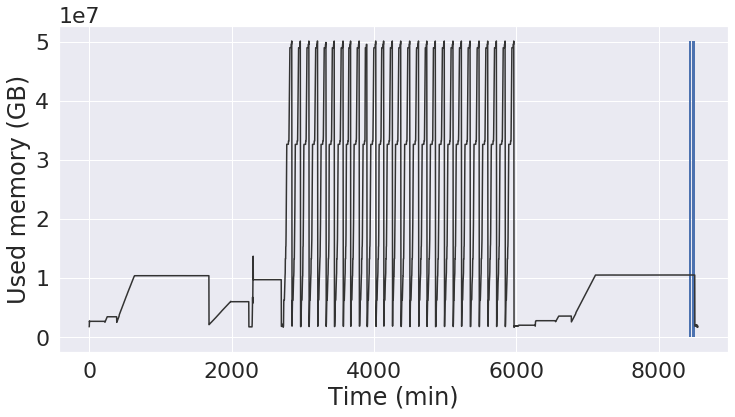

Dynamic


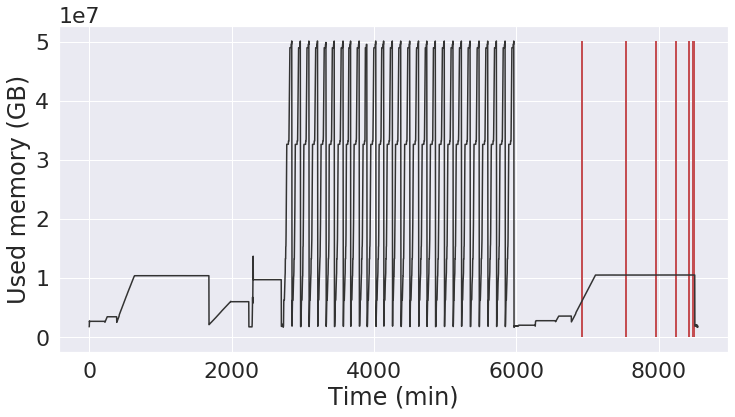

In [17]:
# plot the sequences over one of the example runs

memory_run = np.loadtxt("logs/SLANT_run2.mem", delimiter=',')

def plot_sequence_with_memory(sequence, color='b'):
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(12,6))

    # plot the memory usage
    plt.plot([i[0] for i in memory_run],
             [i[1] for i in memory_run], color="#333333")
    maxy = max([i[1] for i in memory_run])
    # plot static sequence
    ax.vlines(sequence[0][0], 0, maxy, colors=color, lw=2,
              linestyles='solid')
    past_exec = sequence[0][0]
    for i in range(1,len(sequence)):
        ax.vlines(past_exec + sequence[i][0], 0, maxy, colors=color, lw=2, linestyles='solid')
        past_exec += sequence[i][0]

    ax.set_ylabel('Used memory (GB)')
    ax.set_xlabel('Time (min)')
    plt.show()

print("Static")
plot_sequence_with_memory(sequence_static, 'b')
print("Dynamic")
plot_sequence_with_memory(sequence, 'r')

Static


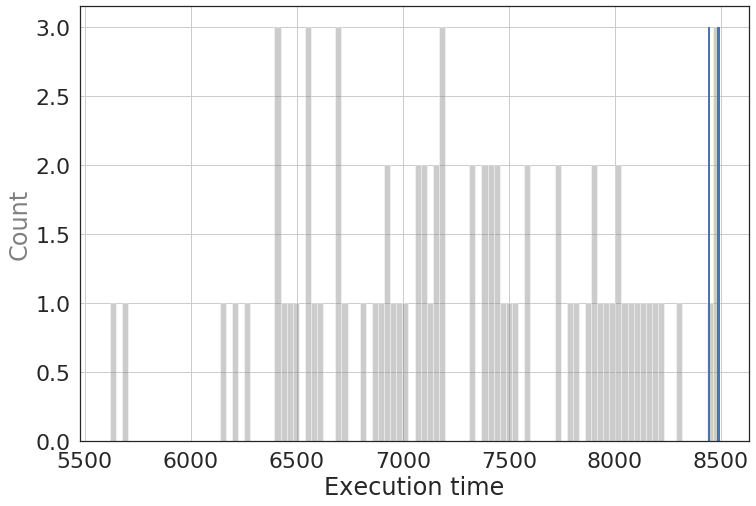

Dynamic


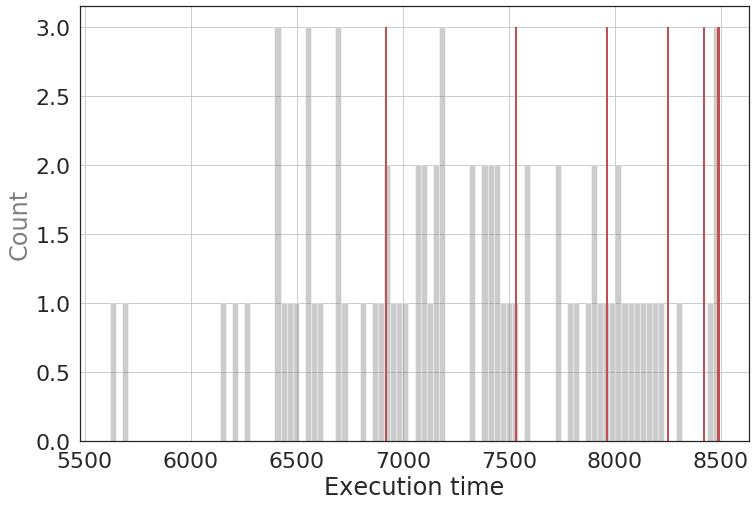

In [18]:
# plot the walltime data and both the sequences

def plot_sequence_with_walltime(sequence, color='b'):
    sns.set(font_scale=2)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(12,8))
    # plot data
    counts, bins = np.histogram(history, bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.4, color="grey")

    # plot dynamic sequence
    ax.vlines(sequence[0][0], min(counts), max(counts), colors=color, lw=2,
              linestyles='solid', label='dynamic memory')
    past_exec = sequence[0][0]
    for i in range(1,len(sequence)):
        ax.vlines(past_exec + sequence[i][0], min(counts), max(counts), colors=color, lw=2, linestyles='solid')
        past_exec += sequence[i][0]

    plt.grid(True)
    ax.set_xlabel('Execution time')
    ax.set_ylabel('Count', color="grey")
    plt.show()

print("Static")
plot_sequence_with_walltime(sequence_static, 'b')
print("Dynamic")
plot_sequence_with_walltime(sequence, 'r')